## Imports

## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Agregar path para importar ml_utils
sys.path.append(str(Path('.').resolve()))
from ml_utils import evaluate_model, plot_feature_importance, compare_models

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Cargar Datos

In [2]:
DATA_PATH = Path("../.data/processed/")

train_df = pd.read_pickle(DATA_PATH / "train.pkl")

print(f"Train dataset: {train_df.shape}")
print(f"\nDistribución del target:")
print(train_df['target'].value_counts().sort_index())
print(f"\nProporción de disasters: {train_df['target'].mean():.2%}")

Train dataset: (7613, 14)

Distribución del target:
target
0    4342
1    3271
Name: count, dtype: int64

Proporción de disasters: 42.97%


## Preparar Features

Usaremos:
- **7 features numéricas**: text_length, word_count, hashtag_count, mention_count, url_count, uppercase_percentage, punctuation_percentage
- **TF-IDF**: 150 features del texto lematizado (incluye bigrams)
- **Mean Encoding**: 1 feature codificando keywords por su relación con el target

In [3]:
# Features numéricas
numeric_features = [
    'text_length',
    'word_count',
    'hashtag_count',
    'mention_count',
    'url_count',
    'uppercase_percentage',
    'punctuation_percentage'
]

print(f"Features numéricas: {len(numeric_features)}")

# Preparar datasets
X_numeric = train_df[numeric_features]
X_text = train_df['text_lemmatized'].fillna('')
X_keyword = train_df['keyword_clean'].fillna('unknown')
y = train_df['target']

print(f"\nShapes:")
print(f"  X_numeric: {X_numeric.shape}")
print(f"  X_text: {X_text.shape}")
print(f"  X_keyword: {X_keyword.shape}")
print(f"  y: {y.shape}")

Features numéricas: 7

Shapes:
  X_numeric: (7613, 7)
  X_text: (7613,)
  X_keyword: (7613,)
  y: (7613,)


## Split Train/Validation

80/20 split estratificado.

In [4]:
# Split indices - primero separamos los índices
train_idx, val_idx = train_test_split(
    np.arange(len(train_df)),
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

# Ahora separamos usando los índices
X_numeric_train = X_numeric.iloc[train_idx]
X_numeric_val = X_numeric.iloc[val_idx]

X_text_train = X_text.iloc[train_idx]
X_text_val = X_text.iloc[val_idx]

X_keyword_train = X_keyword.iloc[train_idx]
X_keyword_val = X_keyword.iloc[val_idx]

y_train = y.iloc[train_idx]
y_val = y.iloc[val_idx]

print(f"Train set: {len(y_train)} samples")
print(f"Val set: {len(y_val)} samples")
print(f"\nDistribución en train: {y_train.value_counts().to_dict()}")
print(f"Distribución en val: {y_val.value_counts().to_dict()}")

Train set: 6090 samples
Val set: 1523 samples

Distribución en train: {0: 3473, 1: 2617}
Distribución en val: {0: 869, 1: 654}


## Mean Encoding para Keywords

El **Mean Encoding** (Target Encoding) reemplaza cada categoría por la media del target para esa categoría.

Ventajas vs OneHot:
- Reduce dimensionalidad (1 columna vs N columnas)
- Captura relación directa con el target
- Funciona mejor con XGBoost

⚠️ Importante: Solo calculamos las medias en el train set para evitar data leakage.

In [5]:
# Calcular mean encoding en train
keyword_means = train_df.iloc[train_idx].groupby('keyword_clean')['target'].mean()

print("Mean Encoding por Keyword (Top 10):")
print(keyword_means.sort_values(ascending=False).head(10))
print("\nKeywords con menor mean (Top 10):")
print(keyword_means.sort_values().head(10))

# Aplicar encoding
# Usar media global como default para keywords no vistos
global_mean = y_train.mean()

X_keyword_train_encoded = X_keyword_train.map(keyword_means).fillna(global_mean).values.reshape(-1, 1)
X_keyword_val_encoded = X_keyword_val.map(keyword_means).fillna(global_mean).values.reshape(-1, 1)

print(f"\n✅ Mean Encoding aplicado")
print(f"  Train shape: {X_keyword_train_encoded.shape}")
print(f"  Val shape: {X_keyword_val_encoded.shape}")
print(f"  Global mean (para keywords no vistos): {global_mean:.4f}")

Mean Encoding por Keyword (Top 10):
keyword_clean
derailment          1.000000
debris              1.000000
wreckage            1.000000
oil spill           1.000000
outbreak            1.000000
suicide bomber      1.000000
typhoon             0.966667
suicide bombing     0.958333
nuclear disaster    0.923077
bombing             0.913043
Name: target, dtype: float64

Keywords con menor mean (Top 10):
keyword_clean
aftershock     0.000000
body bags      0.029412
wrecked        0.031250
blazing        0.033333
ruin           0.034483
stretcher      0.035714
bloody         0.035714
electrocute    0.037037
traumatised    0.037037
body bag       0.040000
Name: target, dtype: float64

✅ Mean Encoding aplicado
  Train shape: (6090, 1)
  Val shape: (1523, 1)
  Global mean (para keywords no vistos): 0.4297


## Feature Engineering Pipeline

1. StandardScaler para features numéricas
2. TfidfVectorizer para texto (max 150 features, bigrams)
3. Mean Encoding para keywords (ya aplicado)
4. Combinar todo

In [6]:
# 1. Escalar numéricas
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_val_scaled = scaler.transform(X_numeric_val)

# 2. TF-IDF para texto (más features que Model 1)
tfidf = TfidfVectorizer(
    max_features=150,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)  # unigrams y bigrams
)
X_text_train_tfidf = tfidf.fit_transform(X_text_train).toarray()
X_text_val_tfidf = tfidf.transform(X_text_val).toarray()

print("Features transformadas:")
print(f"  Numéricas escaladas: {X_numeric_train_scaled.shape}")
print(f"  TF-IDF (texto + bigrams): {X_text_train_tfidf.shape}")
print(f"  Mean Encoding (keywords): {X_keyword_train_encoded.shape}")

# 3. Combinar
X_train_combined = np.hstack([
    X_numeric_train_scaled,
    X_text_train_tfidf,
    X_keyword_train_encoded
])

X_val_combined = np.hstack([
    X_numeric_val_scaled,
    X_text_val_tfidf,
    X_keyword_val_encoded
])

print("\n✅ Features combinadas:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Validation: {X_val_combined.shape}")

Features transformadas:
  Numéricas escaladas: (6090, 7)
  TF-IDF (texto + bigrams): (6090, 150)
  Mean Encoding (keywords): (6090, 1)

✅ Features combinadas:
  Train: (6090, 158)
  Validation: (1523, 158)


## GridSearchCV - Búsqueda de Hiperparámetros

Buscaremos los mejores hiperparámetros para XGBoost.
Usaremos un grid reducido para hacer pruebas más rápidas.

In [7]:
# Grid de hiperparámetros (reducido para demo)
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1]
}

# Modelo base
xgb_base = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

# F1 scorer
f1_scorer = make_scorer(f1_score)

# GridSearchCV con 5-fold cross-validation
print("Iniciando GridSearchCV para XGBoost...")
print(f"Combinaciones a probar: {np.prod([len(v) for v in param_grid.values()])}")
print("⚠️ Esto puede tomar 15-30 minutos...\n")

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit
grid_search.fit(X_train_combined, y_train)

print("\n✅ GridSearchCV completado")

Iniciando GridSearchCV para XGBoost...
Combinaciones a probar: 48
⚠️ Esto puede tomar 15-30 minutos...

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:31:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.0s



/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.3s

/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.9s

/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   6.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   7.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   7.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   6.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   6.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   6.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   2.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_

/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.1s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   2.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.8s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.4s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   3.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.3s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.7s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.2s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.6s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.0s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.5s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   4.9s


/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=300, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, n_esti

/home/mgismondi/repos/fiuba/alumno/cdd-martinelli/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:33:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ GridSearchCV completado


## Resultados de GridSearchCV

In [8]:
print("=" * 70)
print("RESULTADOS DE GRIDSEARCHCV - XGBOOST".center(70))
print("=" * 70)

print(f"\n🏆 Mejor F1 Score (CV): {grid_search.best_score_:.4f}")
print(f"\n📋 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Top 5 configuraciones
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print(f"\n🔝 Top 5 Configuraciones:")
for idx, row in top_5.iterrows():
    print(f"\n  F1 Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")

print("=" * 70)

                 RESULTADOS DE GRIDSEARCHCV - XGBOOST                 

🏆 Mejor F1 Score (CV): 0.7370

📋 Mejores hiperparámetros:
  colsample_bytree: 0.8
  gamma: 0
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 300
  reg_alpha: 0
  reg_lambda: 1
  subsample: 0.8

🔝 Top 5 Configuraciones:

  F1 Score: 0.7370 (±0.0117)
  Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}

  F1 Score: 0.7364 (±0.0114)
  Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}

  F1 Score: 0.7356 (±0.0093)
  Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}

  F1 Score: 0.7353 (±0.0119)
  Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200

## Evaluación en Validación

        EVALUACIÓN: XGBoost (Best from GridSearchCV)        

📊 Métricas:
  F1 Score:  0.7267  ⭐ (métrica principal)
  Accuracy:  0.7748
  Precision: 0.7587
  Recall:    0.6972


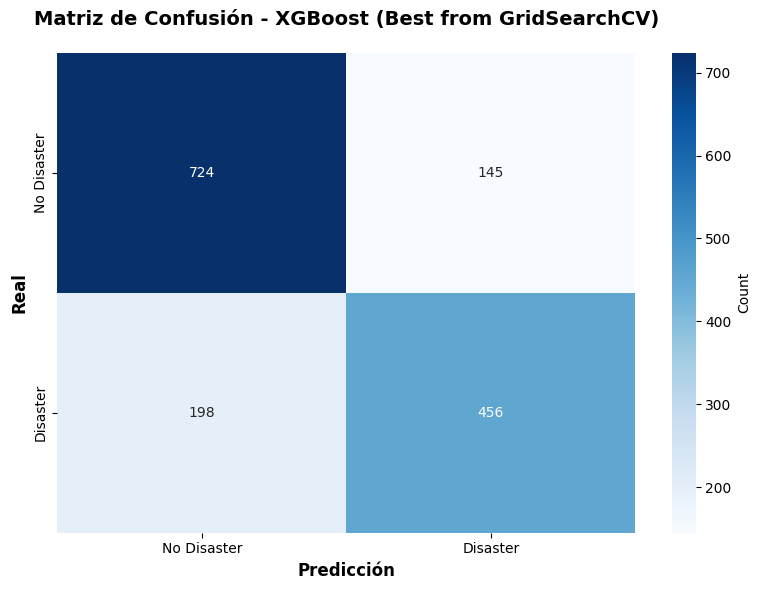


📋 Classification Report:
              precision    recall  f1-score   support

 No Disaster       0.79      0.83      0.81       869
    Disaster       0.76      0.70      0.73       654

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



In [9]:
# Mejor modelo
best_xgb = grid_search.best_estimator_

# Predecir
y_pred_val = best_xgb.predict(X_val_combined)

# Evaluar
results_xgb = evaluate_model(y_val, y_pred_val, "XGBoost (Best from GridSearchCV)")

## Feature Importance

XGBoost proporciona importancia basada en ganancia (gain).

In [10]:
# Construir nombres de features
feature_names = []

# Numéricas
feature_names.extend(numeric_features)

# TF-IDF
tfidf_names = [f"text_{word}" for word in tfidf.get_feature_names_out()]
feature_names.extend(tfidf_names)

# Mean Encoding (1 feature)
feature_names.append('keyword_mean_encoding')

print(f"Total feature names: {len(feature_names)}")
print(f"Total features en modelo: {X_train_combined.shape[1]}")

# Verificar
assert len(feature_names) == X_train_combined.shape[1], \
    "Mismatch entre feature names y número de features"

Total feature names: 158
Total features en modelo: 158


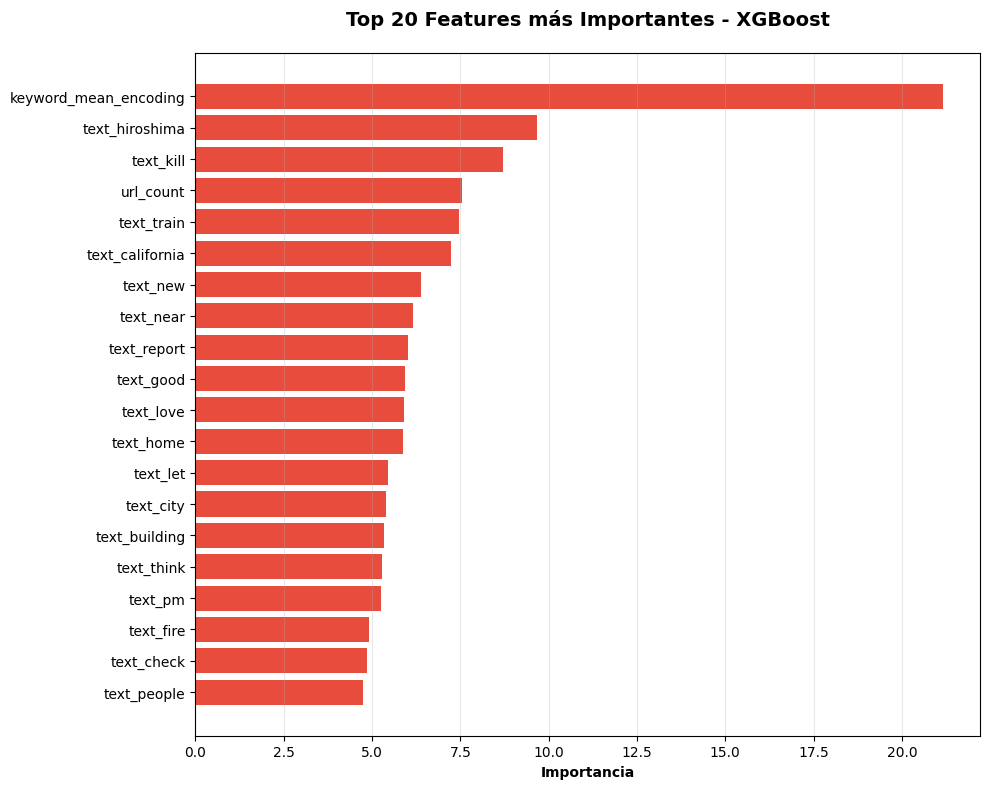


🔝 Top 10 Features Más Importantes:
                   feature  importance
157  keyword_mean_encoding   21.153866
75          text_hiroshima    9.665594
81               text_kill    8.706243
4                url_count    7.539108
137             text_train    7.458917
27         text_california    7.238345
98                text_new    6.386489
96               text_near    6.159564
114            text_report    6.025122
69               text_good    5.925410


In [11]:
# Obtener importancia por ganancia
importance = best_xgb.get_booster().get_score(importance_type='gain')

# Convertir a array (usar 0 si feature no aparece)
importance_array = np.array([importance.get(f'f{i}', 0) for i in range(len(feature_names))])

# Graficar
importance_df = plot_feature_importance(
    feature_names,
    importance_array,
    "XGBoost",
    top_n=20
)

# Mostrar top 10
print("\n🔝 Top 10 Features Más Importantes:")
print(importance_df.head(10).to_string())

## Análisis de Overfitting

In [12]:
# Predecir en train
y_pred_train = best_xgb.predict(X_train_combined)

# Evaluar (sin imprimir)
results_train = evaluate_model(y_train, y_pred_train, print_results=False)
results_val = evaluate_model(y_val, y_pred_val, print_results=False)

# Comparar
comparison = pd.DataFrame({
    'Train': results_train,
    'Validation': results_val,
    'Diferencia': {k: results_train[k] - results_val[k] for k in results_train.keys()}
})

print("=" * 60)
print("COMPARACIÓN TRAIN vs VALIDATION".center(60))
print("=" * 60)
print(comparison.T.to_string())
print("=" * 60)

# Análisis
diff_f1 = results_train['f1'] - results_val['f1']
if diff_f1 > 0.05:
    print(f"\n⚠️ Posible overfitting detectado (diferencia F1: {diff_f1:.4f})")
elif diff_f1 < 0:
    print(f"\n⚠️ Performance mejor en validación que train (diferencia F1: {diff_f1:.4f})")
else:
    print(f"\n✅ Buen balance entre train y validation (diferencia F1: {diff_f1:.4f})")

              COMPARACIÓN TRAIN vs VALIDATION               
                  f1  accuracy  precision    recall
Train       0.833767  0.863547   0.874895  0.796332
Validation  0.726693  0.774787   0.758735  0.697248
Diferencia  0.107074  0.088760   0.116160  0.099084

⚠️ Posible overfitting detectado (diferencia F1: 0.1071)


## Resumen del Modelo

In [13]:
print("=" * 70)
print("RESUMEN: XGBOOST CON GRIDSEARCHCV Y MEAN ENCODING".center(70))
print("=" * 70)

print(f"\n📊 Performance:")
print(f"  F1 Score (CV):         {grid_search.best_score_:.4f}")
print(f"  F1 Score (Train):      {results_train['f1']:.4f}")
print(f"  F1 Score (Validation): {results_val['f1']:.4f}  ⭐")

print(f"\n🎯 Target: F1 > 0.80")
if results_val['f1'] > 0.80:
    print(f"  ✅ OBJETIVO CUMPLIDO (F1 = {results_val['f1']:.4f})")
else:
    print(f"  ❌ Por debajo del objetivo (F1 = {results_val['f1']:.4f})")
    print(f"     Falta: {0.80 - results_val['f1']:.4f}")

print(f"\n🔧 Configuración:")
print(f"  Algoritmo: XGBoost (Gradient Boosting)")
print(f"  Features totales: {X_train_combined.shape[1]}")
print(f"  Encoding keywords: Mean Encoding (Target Encoding)")
print(f"  Búsqueda: GridSearchCV (5-fold CV)")
print(f"  Combinaciones probadas: {len(results_df)}")

print(f"\n🏆 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print("\n" + "=" * 70)

          RESUMEN: XGBOOST CON GRIDSEARCHCV Y MEAN ENCODING           

📊 Performance:
  F1 Score (CV):         0.7370
  F1 Score (Train):      0.8338
  F1 Score (Validation): 0.7267  ⭐

🎯 Target: F1 > 0.80
  ❌ Por debajo del objetivo (F1 = 0.7267)
     Falta: 0.0733

🔧 Configuración:
  Algoritmo: XGBoost (Gradient Boosting)
  Features totales: 158
  Encoding keywords: Mean Encoding (Target Encoding)
  Búsqueda: GridSearchCV (5-fold CV)
  Combinaciones probadas: 48

🏆 Mejores hiperparámetros:
  colsample_bytree: 0.8
  gamma: 0
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 300
  reg_alpha: 0
  reg_lambda: 1
  subsample: 0.8



## Predicciones para Competencia

In [14]:
# Cargar test
test_df = pd.read_pickle(DATA_PATH / "test.pkl")

print(f"Test dataset: {test_df.shape}")

# Preparar features
X_test_numeric = test_df[numeric_features]
X_test_text = test_df['text_lemmatized'].fillna('')
X_test_keyword = test_df['keyword_clean'].fillna('unknown')

# Transformar
X_test_numeric_scaled = scaler.transform(X_test_numeric)
X_test_text_tfidf = tfidf.transform(X_test_text).toarray()
X_test_keyword_encoded = X_test_keyword.map(keyword_means).fillna(global_mean).values.reshape(-1, 1)

# Combinar
X_test_combined = np.hstack([
    X_test_numeric_scaled,
    X_test_text_tfidf,
    X_test_keyword_encoded
])

print(f"Test features combinadas: {X_test_combined.shape}")

# Predecir
test_predictions = best_xgb.predict(X_test_combined)

print(f"\nPredicciones generadas: {len(test_predictions)}")
print(f"Distribución de predicciones:")
print(pd.Series(test_predictions).value_counts().sort_index())

Test dataset: (3263, 13)
Test features combinadas: (3263, 158)

Predicciones generadas: 3263
Distribución de predicciones:
0    1998
1    1265
Name: count, dtype: int64
Test features combinadas: (3263, 158)

Predicciones generadas: 3263
Distribución de predicciones:
0    1998
1    1265
Name: count, dtype: int64


In [15]:
# Crear submission
test_raw = pd.read_csv(Path("../.data/raw/") / "test.csv")
submission = pd.DataFrame({
    'id': test_raw['id'],
    'target': test_predictions
})

# Guardar
OUTPUT_PATH = Path("../.data/submissions/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

submission_file = OUTPUT_PATH / "model2_xgboost.csv"
submission.to_csv(submission_file, index=False)

print(f"✅ Submission guardado en: {submission_file}")
print(f"\nPrimeras 5 filas:")
print(submission.head())
print(f"\nÚltimas 5 filas:")
print(submission.tail())

✅ Submission guardado en: ../.data/submissions/model2_xgboost.csv

Primeras 5 filas:
   id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1

Últimas 5 filas:
         id  target
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       0
3262  10875       1


In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Agregar path para importar ml_utils
sys.path.append(str(Path('.').resolve()))
from ml_utils import evaluate_model, plot_feature_importance, compare_models, COLOR_NO_DISASTER, COLOR_DISASTER, COLOR_GENERAL

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Cargar Datos Avanzados

In [17]:
DATA_PATH = Path("../.data/processed/")

# Cargar datos con features avanzadas
train_df = pd.read_pickle(DATA_PATH / "train_advanced.pkl")

print(f"Train dataset: {train_df.shape}")
print(f"\nDistribución del target:")
print(train_df['target'].value_counts().sort_index())
print(f"\nProporción de disasters: {train_df['target'].mean():.2%}")

FileNotFoundError: [Errno 2] No such file or directory: '../.data/processed/train_advanced.pkl'

## Preparar Features

Usaremos las mismas features que en Model 1, pero con **Mean Encoding** para keywords.

In [ ]:
# Features numéricas básicas
numeric_features_basic = [
    'text_length',
    'word_count',
    'hashtag_count',
    'mention_count',
    'url_count',
    'uppercase_percentage',
    'punctuation_percentage'
]

# Features numéricas avanzadas
numeric_features_advanced = [
    'sentiment_polarity',
    'sentiment_subjectivity',
    'emoji_count',
    'uppercase_word_count',
    'lexical_diversity',
    'number_count',
    'urgency_word_count',
    'intensity_word_count',
    'has_valid_location'
]

# Location features
location_features = ['location_lat', 'location_lon']

# Combinar todas las numéricas
numeric_features = numeric_features_basic + numeric_features_advanced

print(f"Features numéricas: {len(numeric_features)}")
print(f"Features de location: {len(location_features)}")

# Preparar datasets
X_numeric = train_df[numeric_features]
X_location = train_df[location_features].fillna(-999)
X_text = train_df['text_lemmatized'].fillna('')
X_keyword = train_df['keyword_clean'].fillna('unknown')
y = train_df['target']

print(f"\nShapes:")
print(f"  X_numeric: {X_numeric.shape}")
print(f"  X_location: {X_location.shape}")
print(f"  X_text: {X_text.shape}")
print(f"  X_keyword: {X_keyword.shape}")
print(f"  y: {y.shape}")

## Split Train/Validation

80/20 split estratificado.

In [ ]:
# Split indices - primero separamos los índices
train_idx, val_idx = train_test_split(
    np.arange(len(train_df)),
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

# Ahora separamos todo usando los índices
X_numeric_train = X_numeric.iloc[train_idx]
X_numeric_val = X_numeric.iloc[val_idx]

X_location_train = X_location.iloc[train_idx]
X_location_val = X_location.iloc[val_idx]

X_text_train = X_text.iloc[train_idx]
X_text_val = X_text.iloc[val_idx]

X_keyword_train = X_keyword.iloc[train_idx]
X_keyword_val = X_keyword.iloc[val_idx]

y_train = y.iloc[train_idx]
y_val = y.iloc[val_idx]

print(f"Train set: {len(y_train)} samples")
print(f"Val set: {len(y_val)} samples")
print(f"\nDistribución en train: {y_train.value_counts().to_dict()}")
print(f"Distribución en val: {y_val.value_counts().to_dict()}")

## Mean Encoding para Keywords

El **Mean Encoding** (Target Encoding) reemplaza cada categoría por la media del target para esa categoría.

Ventajas vs OneHot:
- Reduce dimensionalidad (1 columna vs N columnas)
- Captura relación directa con el target
- Funciona mejor con XGBoost

⚠️ Importante: Solo calculamos las medias en el train set para evitar data leakage.

In [ ]:
# Calcular mean encoding en train
keyword_means = train_df.iloc[train_idx].groupby('keyword_clean')['target'].mean()

print("Mean Encoding por Keyword:")
print(keyword_means.sort_values(ascending=False).head(10))
print("\nKeywords con menor mean:")
print(keyword_means.sort_values().head(10))

# Aplicar encoding
# Usar media global como default para keywords no vistos
global_mean = y_train.mean()

X_keyword_train_encoded = X_keyword_train.map(keyword_means).fillna(global_mean).values.reshape(-1, 1)
X_keyword_val_encoded = X_keyword_val.map(keyword_means).fillna(global_mean).values.reshape(-1, 1)

print(f"\n✅ Mean Encoding aplicado")
print(f"  Train shape: {X_keyword_train_encoded.shape}")
print(f"  Val shape: {X_keyword_val_encoded.shape}")
print(f"  Global mean (para keywords no vistos): {global_mean:.4f}")

## Feature Engineering Pipeline

1. StandardScaler para features numéricas
2. TfidfVectorizer para texto (max 150 features, incluyendo bigrams)
3. Mean Encoding para keywords (ya aplicado)
4. Combinar todo

In [ ]:
# 1. Escalar numéricas
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_val_scaled = scaler.transform(X_numeric_val)

# 2. Location
location_scaler = StandardScaler()
X_location_train_scaled = location_scaler.fit_transform(X_location_train)
X_location_val_scaled = location_scaler.transform(X_location_val)

# 3. TF-IDF para texto (más features que en Model 1)
tfidf = TfidfVectorizer(
    max_features=150,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)  # unigrams y bigrams
)
X_text_train_tfidf = tfidf.fit_transform(X_text_train).toarray()
X_text_val_tfidf = tfidf.transform(X_text_val).toarray()

print("Features transformadas:")
print(f"  Numéricas escaladas: {X_numeric_train_scaled.shape}")
print(f"  Location escaladas: {X_location_train_scaled.shape}")
print(f"  TF-IDF (texto + bigrams): {X_text_train_tfidf.shape}")
print(f"  Mean Encoding (keywords): {X_keyword_train_encoded.shape}")

# 4. Combinar todas las features
X_train_combined = np.hstack([
    X_numeric_train_scaled,
    X_location_train_scaled,
    X_text_train_tfidf,
    X_keyword_train_encoded
])

X_val_combined = np.hstack([
    X_numeric_val_scaled,
    X_location_val_scaled,
    X_text_val_tfidf,
    X_keyword_val_encoded
])

print("\n✅ Features combinadas:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Validation: {X_val_combined.shape}")

## GridSearchCV - Búsqueda de Hiperparámetros

Buscaremos los mejores hiperparámetros para XGBoost:
- **n_estimators**: número de boosting rounds
- **max_depth**: profundidad máxima de árboles
- **learning_rate**: tasa de aprendizaje
- **subsample**: fracción de muestras por árbol
- **colsample_bytree**: fracción de features por árbol
- **gamma**: mínima reducción de loss para split
- **reg_alpha**: regularización L1
- **reg_lambda**: regularización L2

In [ ]:
# Definir grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Crear modelo base
xgb_base = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

# F1 scorer
f1_scorer = make_scorer(f1_score)

# GridSearchCV con 5-fold cross-validation
print("Iniciando GridSearchCV para XGBoost...")
print(f"Combinaciones totales: {np.prod([len(v) for v in param_grid.values()])}")
print("⚠️ NOTA: Esto puede tomar MUCHO tiempo. Reduciendo grid para demo...")

# Grid reducido para demo (comentar esto y usar param_grid completo si tienes tiempo)
param_grid_reduced = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1]
}

print(f"Usando grid reducido: {np.prod([len(v) for v in param_grid_reduced.values()])} combinaciones")
print("Esto puede tomar varios minutos...\n")

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_reduced,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit
grid_search.fit(X_train_combined, y_train)

print("\n✅ GridSearchCV completado")

## Resultados de GridSearchCV

In [ ]:
print("=" * 70)
print("RESULTADOS DE GRIDSEARCHCV - XGBOOST".center(70))
print("=" * 70)

print(f"\n🏆 Mejor F1 Score (CV): {grid_search.best_score_:.4f}")
print(f"\n📋 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Top 5 configuraciones
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

print(f"\n🔝 Top 5 Configuraciones:")
for idx, row in top_5.iterrows():
    print(f"\n  F1 Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Params: {row['params']}")

print("=" * 70)

## Entrenar Modelo Final con Mejores Hiperparámetros

In [ ]:
# Obtener mejor modelo
best_xgb = grid_search.best_estimator_

print(f"Modelo final: {best_xgb}")
print(f"\nNúmero de features utilizadas: {X_train_combined.shape[1]}")

## Evaluación en Validación

In [ ]:
# Predecir
y_pred_val = best_xgb.predict(X_val_combined)

# Evaluar usando ml_utils
results_xgb = evaluate_model(y_val, y_pred_val, "XGBoost (Best from GridSearchCV)")

## Feature Importance

XGBoost proporciona importancia basada en ganancia (gain).

In [ ]:
# Construir nombres de features
feature_names = []

# Numéricas
feature_names.extend(numeric_features)

# Location
feature_names.extend(['location_lat', 'location_lon'])

# TF-IDF
tfidf_names = [f"text_{word}" for word in tfidf.get_feature_names_out()]
feature_names.extend(tfidf_names)

# Mean Encoding (1 feature)
feature_names.append('keyword_mean_encoding')

print(f"Total feature names: {len(feature_names)}")
print(f"Total features en modelo: {X_train_combined.shape[1]}")

# Verificar
assert len(feature_names) == X_train_combined.shape[1], \
    "Mismatch entre feature names y número de features"

In [ ]:
# Obtener importancia por ganancia
importance = best_xgb.get_booster().get_score(importance_type='gain')

# Convertir a array (usar 0 si feature no aparece)
importance_array = np.array([importance.get(f'f{i}', 0) for i in range(len(feature_names))])

# Usar función de ml_utils para graficar
importance_df = plot_feature_importance(
    feature_names,
    importance_array,
    "XGBoost",
    top_n=20
)

# Mostrar top 10
print("\n🔝 Top 10 Features Más Importantes:")
print(importance_df.head(10).to_string())

## Análisis de Overfitting

In [ ]:
# Predecir en train
y_pred_train = best_xgb.predict(X_train_combined)

# Evaluar (sin imprimir)
results_train = evaluate_model(y_train, y_pred_train, print_results=False)
results_val = evaluate_model(y_val, y_pred_val, print_results=False)

# Comparar
comparison = pd.DataFrame({
    'Train': results_train,
    'Validation': results_val,
    'Diferencia': {k: results_train[k] - results_val[k] for k in results_train.keys()}
})

print("=" * 60)
print("COMPARACIÓN TRAIN vs VALIDATION".center(60))
print("=" * 60)
print(comparison.T.to_string())
print("=" * 60)

# Análisis
diff_f1 = results_train['f1'] - results_val['f1']
if diff_f1 > 0.05:
    print(f"\n⚠️ Posible overfitting detectado (diferencia F1: {diff_f1:.4f})")
elif diff_f1 < 0:
    print(f"\n⚠️ Performance mejor en validación que train (diferencia F1: {diff_f1:.4f})")
else:
    print(f"\n✅ Buen balance entre train y validation (diferencia F1: {diff_f1:.4f})")

## Resumen del Modelo

In [ ]:
print("=" * 70)
print("RESUMEN: XGBOOST CON GRIDSEARCHCV Y MEAN ENCODING".center(70))
print("=" * 70)

print(f"\n📊 Performance:")
print(f"  F1 Score (CV):         {grid_search.best_score_:.4f}")
print(f"  F1 Score (Train):      {results_train['f1']:.4f}")
print(f"  F1 Score (Validation): {results_val['f1']:.4f}  ⭐")

print(f"\n🎯 Target: F1 > 0.80")
if results_val['f1'] > 0.80:
    print(f"  ✅ OBJETIVO CUMPLIDO (F1 = {results_val['f1']:.4f})")
else:
    print(f"  ❌ Por debajo del objetivo (F1 = {results_val['f1']:.4f})")
    print(f"     Falta: {0.80 - results_val['f1']:.4f}")

print(f"\n🔧 Configuración:")
print(f"  Algoritmo: XGBoost (Gradient Boosting)")
print(f"  Features totales: {X_train_combined.shape[1]}")
print(f"  Encoding keywords: Mean Encoding (Target Encoding)")
print(f"  Búsqueda: GridSearchCV (5-fold CV)")
print(f"  Combinaciones probadas: {len(results_df)}")

print(f"\n🏆 Mejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print("\n" + "=" * 70)

## Predicciones para Competencia

In [ ]:
# Cargar test
test_df = pd.read_pickle(DATA_PATH / "test_advanced.pkl")

print(f"Test dataset: {test_df.shape}")

# Preparar features
X_test_numeric = test_df[numeric_features]
X_test_location = test_df[location_features].fillna(-999)
X_test_text = test_df['text_lemmatized'].fillna('')
X_test_keyword = test_df['keyword_clean'].fillna('unknown')

# Transformar
X_test_numeric_scaled = scaler.transform(X_test_numeric)
X_test_location_scaled = location_scaler.transform(X_test_location)
X_test_text_tfidf = tfidf.transform(X_test_text).toarray()
X_test_keyword_encoded = X_test_keyword.map(keyword_means).fillna(global_mean).values.reshape(-1, 1)

# Combinar
X_test_combined = np.hstack([
    X_test_numeric_scaled,
    X_test_location_scaled,
    X_test_text_tfidf,
    X_test_keyword_encoded
])

print(f"Test features combinadas: {X_test_combined.shape}")

# Predecir
test_predictions = best_xgb.predict(X_test_combined)

print(f"\nPredicciones generadas: {len(test_predictions)}")
print(f"Distribución de predicciones:")
print(pd.Series(test_predictions).value_counts().sort_index())

In [ ]:
# Crear submission
test_raw = pd.read_csv(Path("../.data/raw/") / "test.csv")
submission = pd.DataFrame({
    'id': test_raw['id'],
    'target': test_predictions
})

# Guardar
OUTPUT_PATH = Path("../.data/submissions/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

submission_file = OUTPUT_PATH / "model2_xgboost.csv"
submission.to_csv(submission_file, index=False)

print(f"✅ Submission guardado en: {submission_file}")
print(f"\nPrimeras 5 filas:")
print(submission.head())
print(f"\nÚltimas 5 filas:")
print(submission.tail())